In [1]:
from torchvision import transforms    #Used to transform and preprocess images.
from torch.utils.data import DataLoader    #Helps in loading data efficiently in batches.
import torch.nn as nn     #Used to define the neural network layers.
import torch    #PyTorch main library for deep learning.
from torchvision import models   #Contains pretrained deep learning models (like ResNet).
import torch.optim as optim     #Optimization algorithms for training (like Adam).
import os     #Helps in handling file paths and directory operations.
from PIL import Image    #Used to open and process images.
import matplotlib.pyplot as plt     #Helps in plotting graphs (e.g., loss curves).
import torch.nn.functional as F

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import clip
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
clip_model, preprocess = clip.load("ViT-B/32", device=device)

cuda


In [4]:
from sklearn.metrics import precision_score

In [5]:
# Define dataset paths (Update paths as needed)
qa_path = r"C:\Users\cscpr\Desktop\PAPER\VQA CONFERENCE 3\eoc_vqa\all_qa_pairs.txt"   # Questions and answers
train_image_list = r"C:\Users\cscpr\Desktop\PAPER\VQA CONFERENCE 3\eoc_vqa\train_images_list.txt"   #List of training images
test_image_list = r"C:\Users\cscpr\Desktop\PAPER\VQA CONFERENCE 3\eoc_vqa\test_images_list.txt"   # List of testing images
answer_space_path = r"C:\Users\cscpr\Desktop\PAPER\VQA CONFERENCE 3\eoc_vqa\answer_space.txt"      #List of all possible answers

In [6]:
# Read train and test image names
with open(train_image_list, "r") as f:
    train_images = set(f.read().splitlines())

with open(test_image_list, "r") as f:
    test_images = set(f.read().splitlines())

# Load all question-answer pairs
qa_pairs = []
with open(qa_path, "r") as f:
    lines = f.read().splitlines()
    for i in range(0, len(lines), 2):  # Every two lines (question, answer)
        question = lines[i]
        answer = lines[i + 1]
        image_name = question.split("in the ")[-1].split(" ?")[0]  # Extract image name
        if image_name:  # Ensure image name exists
            qa_pairs.append({"image": image_name, "question": question, "answer": answer})

# Split dataset based on image names
train_data = [qa for qa in qa_pairs if qa["image"] in train_images]
test_data = [qa for qa in qa_pairs if qa["image"] in test_images]

print(f"Training Samples: {len(train_data)}, Testing Samples: {len(test_data)}")

Training Samples: 6630, Testing Samples: 5542


In [7]:
class DAQUARDataset():
    def __init__(self, qa_data, image_folder, transform, answer_to_index):
        self.qa_data = qa_data
        self.image_folder = image_folder
        self.transform = transform
        self.answer_to_index = answer_to_index

    def __len__(self):
        return len(self.qa_data)

    def __getitem__(self, idx):
        sample = self.qa_data[idx]
        image_path = os.path.join(self.image_folder, sample["image"] + ".png")
        question = sample["question"]
        answer = sample["answer"]

        # Load and preprocess image
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)

        # Encode question using CLIP
        text_features = clip.tokenize([question]).to(device)
        with torch.no_grad():
            text_features = clip_model.encode_text(text_features)

        text_features = text_features.squeeze(0)  # Shape: [512]

        # Convert answer to index with safeguard
        if answer not in self.answer_to_index:
          pass
            # print(f"Warning: Answer '{answer}' not found in answer space.")
        answer_index = self.answer_to_index.get(answer, 0)  # Default to 0 if not found

        return image, text_features, answer_index

In [8]:
# Load answer space and create answer-to-index mapping
with open(answer_space_path, "r") as f:
    answers_list = f.read().splitlines()

answer_to_index = {answer: idx for idx, answer in enumerate(answers_list)}
num_classes = len(answer_to_index)

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define dataset paths (update as needed)
image_folder = r"C:\Users\cscpr\Desktop\PAPER\VQA CONFERENCE 3\eoc_vqa\images" # Update this

# Create training & testing datasets
train_dataset = DAQUARDataset(train_data, image_folder, transform, answer_to_index)
test_dataset = DAQUARDataset(test_data, image_folder, transform, answer_to_index)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")


Train size: 6630, Test size: 5542


In [9]:
class VQAModel(nn.Module):
    def __init__(self, num_classes):
        super(VQAModel, self).__init__()

        # Load Pretrained ResNet for Image Features
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Identity()  # Remove last FC layer

        # CLIP already gives a 512-dim text feature, so no need for text_fc
        self.fc = nn.Linear(512 + 512, num_classes)  # Combine image & text features

    def forward(self, image, text):
        image_features = self.resnet(image)  # Extract image features
        combined = torch.cat((image_features, text), dim=1)  # Combine image & text
        output = self.fc(combined)  # Predict answer
        return output

In [10]:
# Set device (Use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, loss function, optimizer
model = VQAModel(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
from sklearn.metrics import precision_score

# Training loop with accuracy and precision tracking
num_epochs = 100
epoch_losses = []  # Store loss values
epoch_accuracies = []  # Store accuracy values
epoch_precisions = []  # Store precision values

print("Training")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    for images, text_features, answer_indices in train_loader:
        images, text_features, answer_indices = images.to(device), text_features.to(device), answer_indices.to(device)

        optimizer.zero_grad()
        output = model(images, text_features)

        loss = criterion(output, answer_indices)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(output, 1)
        correct += (predicted == answer_indices).sum().item()
        total += answer_indices.size(0)

        # Store predictions and labels for precision calculation
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(answer_indices.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total * 100  # Convert to percentage
    precision = precision_score(all_labels, all_preds, average='weighted') * 100  # Weighted precision

    epoch_losses.append(avg_loss)
    epoch_accuracies.append(accuracy)
    epoch_precisions.append(precision)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.2f}%, Precision: {precision:.2f}%")


print("Training Complete!")

Training
Epoch 1/100, Loss: 1897.7342, Accuracy: 15.11%, Precision: 9.22%
Epoch 2/100, Loss: 1522.5615, Accuracy: 22.29%, Precision: 15.77%
Epoch 3/100, Loss: 1353.6626, Accuracy: 25.91%, Precision: 20.75%
Epoch 4/100, Loss: 1235.9883, Accuracy: 29.05%, Precision: 24.41%
Epoch 5/100, Loss: 1144.8814, Accuracy: 31.63%, Precision: 28.15%
Epoch 6/100, Loss: 1077.1060, Accuracy: 34.75%, Precision: 32.15%
Epoch 7/100, Loss: 1020.2854, Accuracy: 36.76%, Precision: 35.63%
Epoch 8/100, Loss: 973.9340, Accuracy: 39.70%, Precision: 39.64%
Epoch 9/100, Loss: 934.8166, Accuracy: 41.61%, Precision: 41.68%
Epoch 10/100, Loss: 896.4011, Accuracy: 43.42%, Precision: 43.69%
Epoch 11/100, Loss: 869.5173, Accuracy: 44.54%, Precision: 45.31%
Epoch 12/100, Loss: 840.3823, Accuracy: 45.90%, Precision: 46.52%
Epoch 13/100, Loss: 814.2114, Accuracy: 47.53%, Precision: 48.18%
Epoch 14/100, Loss: 790.3974, Accuracy: 48.48%, Precision: 49.46%
Epoch 15/100, Loss: 768.8197, Accuracy: 49.71%, Precision: 50.61%
Epoc

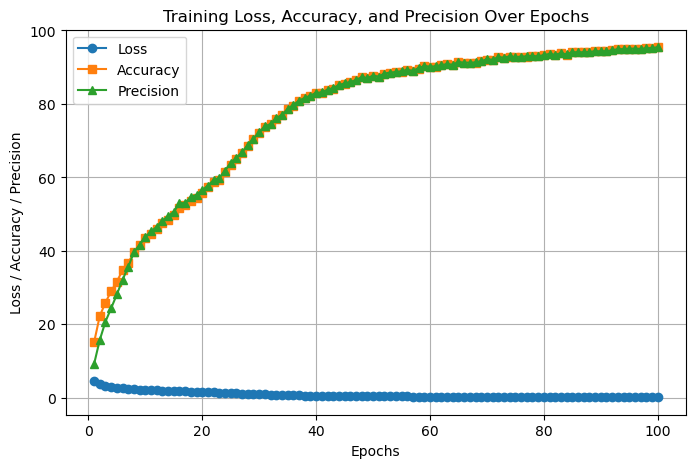

In [11]:
# Plot Loss, Accuracy & Precision
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', linestyle='-', label="Loss")
plt.plot(range(1, num_epochs + 1), epoch_accuracies, marker='s', linestyle='-', label="Accuracy")
plt.plot(range(1, num_epochs + 1), epoch_precisions, marker='^', linestyle='-', label="Precision")
plt.xlabel("Epochs")
plt.ylabel("Loss / Accuracy / Precision")
plt.title("Training Loss, Accuracy, and Precision Over Epochs")
plt.legend()
plt.grid()
plt.show()

In [14]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, text_features, answer_indices in test_loader:
            images, text_features, answer_indices = images.to(device), text_features.to(device), answer_indices.to(device)

            output = model(images, text_features)
            _, predicted = torch.max(output, 1)

            correct += (predicted == answer_indices).sum().item()
            total += answer_indices.size(0)

            # Store predictions and true labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(answer_indices.cpu().numpy())

    # Calculate Accuracy
    accuracy = correct / total * 100  # Convert to percentage

    # Calculate Precision (weighted for imbalanced classes)
    precision = precision_score(all_labels, all_preds, average='weighted') * 100

    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Test Precision: {precision:.2f}%")

# Run the test function
test_model(model, test_loader)

Test Accuracy: 25.24%
Test Precision: 23.62%


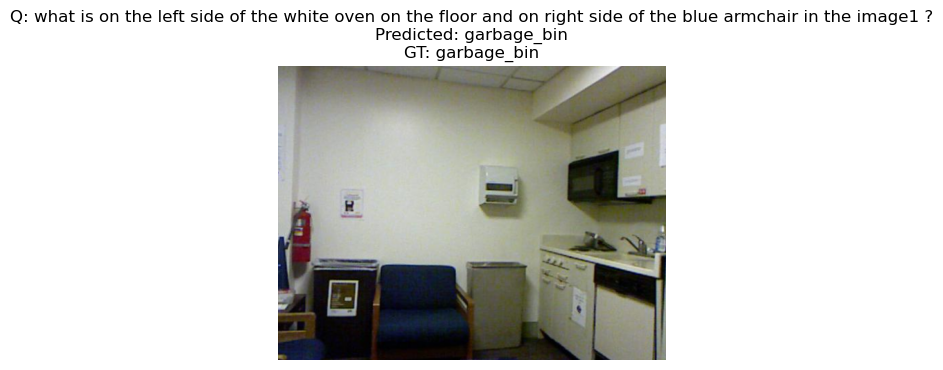

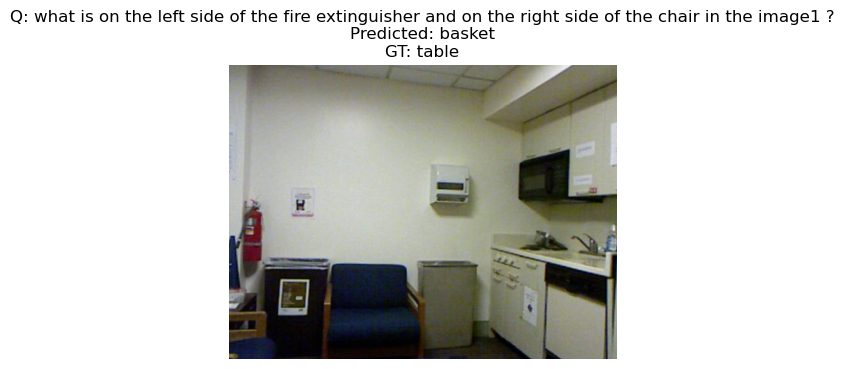

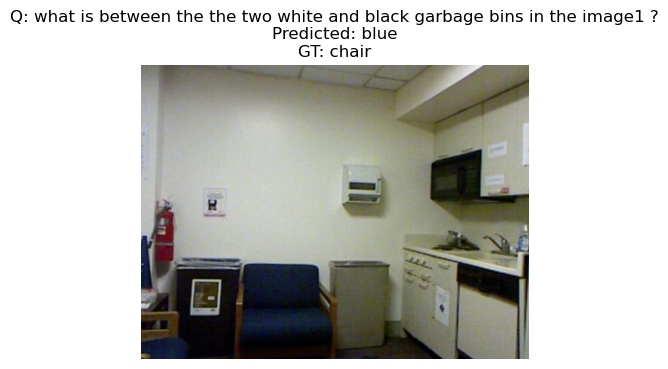

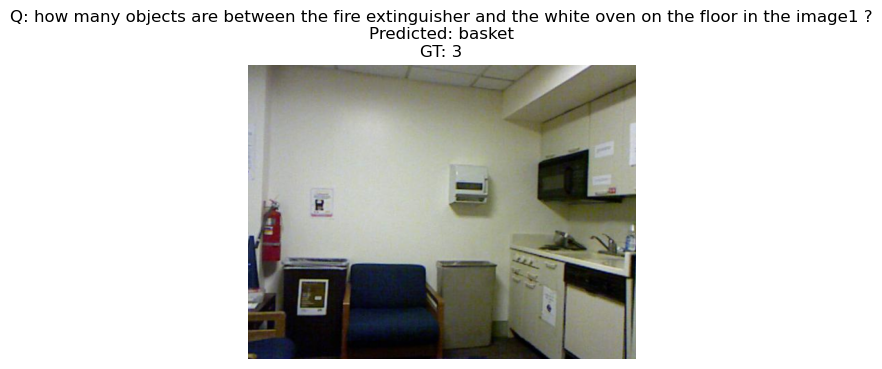

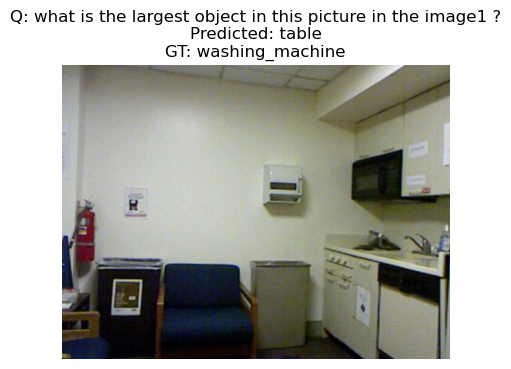

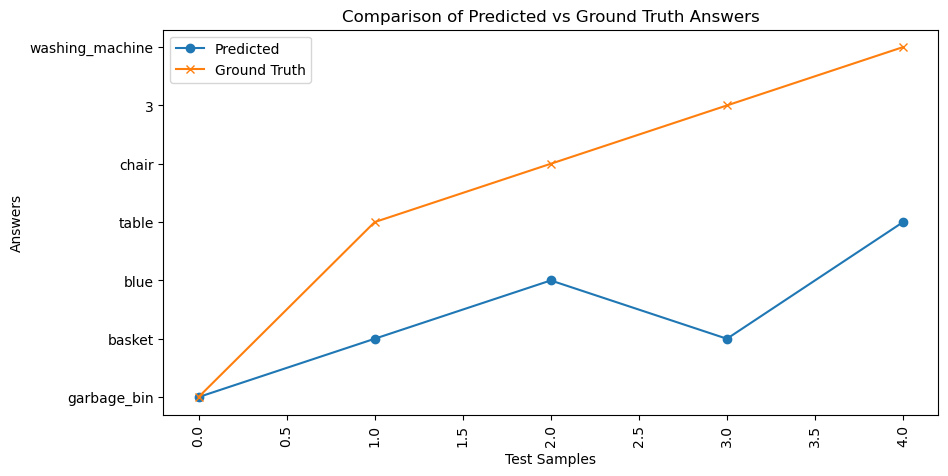

In [15]:
# Function to test the model on multiple examples and plot results
def test_vqa_with_plot(test_samples):
    predicted_answers = []
    ground_truth_answers = []

    for sample in test_samples:
        image_path = os.path.join(image_folder, sample["image"] + ".png")  # Update extension if needed
        question = sample["question"]
        ground_truth_answer = sample["answer"]

        # Load and preprocess image
        image = Image.open(image_path).convert("RGB")
        image_tensor = transform(image).unsqueeze(0).to(device)

        # Encode question using CLIP (✅ Fix indentation)
        text_features = clip.tokenize([question]).to(device)
        with torch.no_grad():
            text_features = clip_model.encode_text(text_features)

        # Run inference
        with torch.no_grad():
            output = model(image_tensor, text_features)

        # Convert output to predicted answer
        probs = F.softmax(output, dim=1)
        predicted_index = torch.argmax(probs, dim=1).item()
        predicted_answer = answers_list[predicted_index] if predicted_index < len(answers_list) else "Unknown"

        predicted_answers.append(predicted_answer)
        ground_truth_answers.append(ground_truth_answer)

        # Display results
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.title(f"Q: {question}\nPredicted: {predicted_answer}\nGT: {ground_truth_answer}")
        plt.axis("off")
        plt.show()

    # Plot comparison graph
    plt.figure(figsize=(10, 5))
    plt.plot(predicted_answers, label="Predicted", marker='o')
    plt.plot(ground_truth_answers, label="Ground Truth", marker='x')
    plt.xlabel("Test Samples")
    plt.ylabel("Answers")
    plt.title("Comparison of Predicted vs Ground Truth Answers")
    plt.legend()
    plt.xticks(rotation=90)
    plt.show()


# Test on a few examples
test_vqa_with_plot(test_data[:5])